# Generating sentiment scores

In [1]:
import pandas as pd
import os,re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from afinn import Afinn
afinn = Afinn(language='en')

In [2]:
base_path = "/Users/leah/Desktop/NLP Group"

In [3]:
locations = pd.read_csv(base_path + os.sep + "locations.csv")  
locations_df = locations.dropna(axis=0,how='any') 
locations_df = locations_df[locations_df.Children==False]

In [4]:
locations_df

,Date,Company,Path,SpecificDate,Children
2,2010Q4,ABT,/pure_articles/ABT/2011-01-26T19:05:13-05:00_A...,2011-01-26T19:05:13-05:00,False
5,2010Q4,AMD,/pure_articles/AMD/2011-01-21T11:39:30-05:00_A...,2011-01-21T11:39:30-05:00,False
6,2010Q4,AMZN,/pure_articles/AMZN/2011-01-27T23:05:19-05:00_...,2011-01-27T23:05:19-05:00,False
8,2010Q4,BAC,/pure_articles/BAC/2011-01-21T16:05:23-05:00_B...,2011-01-21T16:05:23-05:00,False
9,2010Q4,CMCSA,/pure_articles/CMCSA/2011-02-16T15:30:00-05:00...,2011-02-16T15:30:00-05:00,False
...,...,...,...,...,...
2611,2022Q3,NVDA,/pure_articles/NVDA/2021-11-18T00:02:04-05:00_...,2021-11-18T00:02:04-05:00,False
2625,2022Q3,WMT,/pure_articles/WMT/2021-11-16T12:04:06-05:00_W...,2021-11-16T12:04:06-05:00,False
2638,2022Q4,CRM,/pure_articles/CRM/2022-03-01T21:18:01-05:00_S...,2022-03-01T21:18:01-05:00,False
2659,2022Q4,NVDA,/pure_articles/NVDA/2022-02-16T22:12:03-05:00_...,2022-02-16T22:12:03-05:00,False


In [5]:
def clean_data(content):
    
    content = content.lower() # change to lower case for better data cleaning
    
    # lemmatize the words
    word_pattern = re.compile('\w+')
    words = word_pattern.findall(content)
    lemma_content = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]

    # remove stopwords
    english_stop_words = stopwords.words('english')
    lemma_english_stopwords = [WordNetLemmatizer().lemmatize(w, pos='v') for w in english_stop_words]
    processed_content = [word for word in lemma_content if word not in lemma_english_stopwords]
    
    return processed_content

In [6]:
def get_data(index,afinn_dict):

    ticker = locations_df['Company'].iloc[index]
    file_path = locations_df['Path'].iloc[index]
    
    
    quarter = locations_df['Date'].iloc[index]
    date = locations_df['SpecificDate'].iloc[index][:10]
    
    f = open(base_path +file_path)
    content = f.read()
    
    # clean the texts
    processed_content = clean_data(content=content)

    # std_df is for temporary saving of sentiment scores of every word from the file now being processed
    std_df = {}
    std_df['word'] = pd.Series(processed_content)
    std_df['afinn_score'] = std_df['word'].apply(afinn.score)

    count = std_df['afinn_score'].count()
    afinn_score_sum =  std_df['afinn_score'].sum()
    afinn_score_mean = std_df['afinn_score'].mean()
    afinn_score_med = std_df['afinn_score'].median()
    afinn_score_std = std_df['afinn_score'].std()

    # preserve the results to the afinn_dict
    afinn_dict.update({file_path:{'Ticker':ticker,'Quarter':quarter,'Date':date,'Total_Words':count,'Sum': afinn_score_sum, 'Mean':afinn_score_mean,
                                    'Median':afinn_score_med, 'Std':afinn_score_std,
                                    '%Positive': ((std_df['afinn_score']>0).sum()/count*100),
                                    '%Negative': ((std_df['afinn_score']<0).sum()/count*100),
                                    '%Neutral': ((std_df['afinn_score']==0).sum()/count*100)}})


In [7]:
from multiprocess import Pool
from multiprocess import Manager
import time

In [8]:
if __name__ == '__main__':
    
    start_time = time.time()
    
    total = len(locations_df) # total number of loops
    # generating a shared dictionary through the pools to save and pass the results
    afinn_dict = Manager().dict() 
    
    p = Pool(10)
    for i in range(total):
        p.apply_async(get_data, args=(i , afinn_dict))
    p.close()
    p.join()
    
    print("--- %s seconds ---" % (time.time() - start_time)) # 54.793590784072876 seconds
    print('after pool:  {}'.format(afinn_dict))

--- 54.793590784072876 seconds ---
after pool:  {'/pure_articles/AMD/2011-01-21T11:39:30-05:00_Advanced Micro Devices CEO Discusses Q4 2010 Earnings Call Transcript.html': {'Ticker': 'AMD', 'Quarter': '2010Q4', 'Date': '2011-01-21', 'Total_Words': 5038, 'Sum': 893.0, 'Mean': 0.17725287812624058, 'Median': 0.0, 'Std': 0.6473343241212097, '%Positive': 10.599444223898374, '%Negative': 1.2703453751488685, '%Neutral': 88.13021040095276}, "/pure_articles/JNJ/2011-01-25T19:05:12-05:00_Johnson & Johnson's CEO Discusses Q4 2010 Results - Earnings Call Transcript.html": {'Ticker': 'JNJ', 'Quarter': '2010Q4', 'Date': '2011-01-25', 'Total_Words': 10213, 'Sum': 1243.0, 'Mean': 0.12170762753353569, 'Median': 0.0, 'Std': 0.5525390436243828, '%Positive': 8.40105747576618, '%Negative': 1.8799569176539705, '%Neutral': 89.71898560657985}, "/pure_articles/DHR/2011-01-27T15:05:16-05:00_Danaher's CEO Discusses Q4 2010 Results - Earnings Call Transcript.html": {'Ticker': 'DHR', 'Quarter': '2010Q4', 'Date': '

In [9]:
afinn_df = pd.DataFrame.from_dict(dict(afinn_dict), orient='index')
afinn_df = afinn_df.reset_index()
afinn_df = afinn_df.sort_values(by=['Ticker','Quarter'])
afinn_df = afinn_df.drop(['index'],axis = 1)

In [10]:
afinn_df 

,Ticker,Quarter,Date,Total_Words,Sum,Mean,Median,Std,%Positive,%Negative,%Neutral
25,AAPL,2011Q1,2011-01-18,4969,830.0,0.167036,0.0,0.612760,9.579392,0.905615,89.514993
60,AAPL,2011Q2,2011-04-20,5552,979.0,0.176333,0.0,0.640658,10.122478,1.314841,88.562680
100,AAPL,2011Q3,2011-07-19,5106,842.0,0.164904,0.0,0.616640,9.439875,0.998825,89.561300
141,AAPL,2011Q4,2011-10-18,5483,816.0,0.148824,0.0,0.596805,8.699617,1.094291,90.206092
184,AAPL,2012Q1,2012-01-24,5282,769.0,0.145589,0.0,0.583988,8.481636,0.965543,90.552821
...,...,...,...,...,...,...,...,...,...,...,...
1879,XOM,2020Q4,2021-02-02,7879,1219.0,0.154715,0.0,0.602567,9.582434,1.688031,88.729534
1923,XOM,2021Q1,2021-04-30,6567,967.0,0.147251,0.0,0.577870,8.953860,1.522765,89.523374
1972,XOM,2021Q2,2021-07-30,7354,1241.0,0.168752,0.0,0.592301,9.940169,1.087843,88.971988
2019,XOM,2021Q3,2021-10-29,6090,1175.0,0.192939,0.0,0.644378,11.198686,1.395731,87.405583


In [11]:
afinn_df.to_csv(base_path + os.sep + 'sentiment_data.csv',encoding='utf-8',index = False)

## Acquiring Stock Prices

In [12]:
import pandas_datareader as pdr
import datetime

In [13]:
# afinn_df = pd.read_csv(base_path + os.sep + 'sentiment_data.csv',encoding='utf-8')
tickers = afinn_df.Ticker.unique()

In [14]:
start_date = datetime.datetime(2011,1,1) #'2011-01-01'
end_date = datetime.datetime(2022,3,8) #'2022-03-08'
data = pdr.get_data_yahoo(tickers,start_date,end_date)

In [15]:
insert_prices = data.loc[:,'Adj Close'] # keep the adjusted close prices
insert_prices.columns.names = ['Ticker']
insert_prices = insert_prices.fillna(0)
insert_prices.to_csv(base_path + os.sep + 'prices.csv',encoding = 'utf-8')
print(insert_prices)

Ticker            AAPL        ABBV         ABT         ACN        ADBE  \
Date                                                                     
2010-12-31    9.864280    0.000000   16.677647   39.143623   30.780001   
2011-01-03   10.078657    0.000000   16.646320   39.224342   31.290001   
2011-01-04   10.131255    0.000000   16.802969   38.966015   31.510000   
2011-01-05   10.214131    0.000000   16.802969   38.974094   32.220001   
2011-01-06   10.205872    0.000000   16.768150   39.119396   32.270000   
...                ...         ...         ...         ...         ...   
2022-03-02  166.559998  149.570007  120.360001  318.329987  471.179993   
2022-03-03  166.229996  150.410004  120.970001  318.950012  459.079987   
2022-03-04  163.169998  150.559998  121.410004  314.160004  452.130005   
2022-03-07  159.300003  149.449997  118.860001  305.019989  437.970001   
2022-03-08  157.440002  147.149994  116.110001  301.619995  431.529999   

Ticker             AMD         AMZN  

## Factor Analysis

In [47]:
import alphalens as al

In [48]:
'''
To get the complexity analysis result, run the codes below, and change 
all_factors = pd.merge(afinn_df,new_prices, on = ['Ticker','Date'], how = 'right')
to 
all_factors = pd.merge(factors_df,new_prices, on = ['Ticker','Date'], how = 'right')
in the next sector
'''
# factors_df = pd.read_csv(base_path + os.sep + "senti_complex_combine_220318.csv",encoding ='utf-8') # read the factor data combined with complexity factors
# factors_df = factors_df.iloc[:,1:]

"\nTo get the complexity analysis result, run the codes below, and change \nall_factors = pd.merge(afinn_df,new_prices, on = ['Ticker','Date'], how = 'right')\nto \nall_factors = pd.merge(factors_df,new_prices, on = ['Ticker','Date'], how = 'right')\nin the next sector\n"

In [49]:
prices = pd.read_csv(base_path + os.sep + 'prices.csv',encoding = 'utf-8')
prices = prices.set_index(['Date'])
prices_df = pd.DataFrame(prices.stack())
prices_df.columns = ['Adj_close']
prices_df.index.names = ['Date','Ticker']
new_prices = prices_df.reset_index()
all_factors = pd.merge(afinn_df,new_prices, on = ['Ticker','Date'], how = 'right')
# all_factors = pd.merge(factors_df,new_prices, on = ['Ticker','Date'], how = 'right') # run this instead of the previous line to get the complexity analysis
all_factors = all_factors.sort_values(by = ['Ticker', 'Date'])

In [50]:
# fill the days when no earning call was released
for factor in (all_factors.columns[1:-1]):
    all_factors[factor] = all_factors[factor].fillna(method='pad',axis=0)

all_factors.to_csv(base_path + os.sep + 'all_factors_value_insert_220318.csv',index=False)

In [51]:
all_factors

,Ticker,Quarter,Date,Total_Words,Sum,Mean,Median,Std,%Positive,%Negative,%Neutral,Adj_close
0,AAPL,NaN,2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.864280
48,AAPL,NaN,2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.078657
96,AAPL,NaN,2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.131255
144,AAPL,NaN,2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.214131
192,AAPL,NaN,2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.205872
...,...,...,...,...,...,...,...,...,...,...,...,...
134927,XOM,2021Q4,2022-03-02,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,80.529999
134975,XOM,2021Q4,2022-03-03,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,81.040001
135023,XOM,2021Q4,2022-03-04,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,84.089996
135071,XOM,2021Q4,2022-03-07,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,87.120003


In [32]:
factor_insert_df = pd.read_csv(base_path + os.sep + 'all_factors_value_insert_220318.csv') # factor dataset fulfilled daily, combined with complexity factors
factor_insert_df = factor_insert_df.drop(columns = ['Quarter'])
factor_insert_df = factor_insert_df.dropna()
factor_insert_df = factor_insert_df[(factor_insert_df.Ticker != 'ABBV') &(factor_insert_df.Ticker != 'FB')  ]

In [33]:
factor_insert_df

,Ticker,Date,Total_Words,Sum,Mean,Median,Std,%Positive,%Negative,%Neutral,Adj_close
11,AAPL,2011-01-18,4969.0,830.0,0.167036,0.0,0.612760,9.579392,0.905615,89.514993,10.417496
12,AAPL,2011-01-19,4969.0,830.0,0.167036,0.0,0.612760,9.579392,0.905615,89.514993,10.362144
13,AAPL,2011-01-20,4969.0,830.0,0.167036,0.0,0.612760,9.579392,0.905615,89.514993,10.173764
14,AAPL,2011-01-21,4969.0,830.0,0.167036,0.0,0.612760,9.579392,0.905615,89.514993,9.991500
15,AAPL,2011-01-24,4969.0,830.0,0.167036,0.0,0.612760,9.579392,0.905615,89.514993,10.319635
...,...,...,...,...,...,...,...,...,...,...,...
135115,XOM,2022-03-02,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,80.529999
135116,XOM,2022-03-03,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,81.040001
135117,XOM,2022-03-04,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,84.089996
135118,XOM,2022-03-07,5719.0,1231.0,0.215247,0.0,0.660168,12.222417,0.961707,86.815877,87.120003


In [34]:
insert_prices = insert_prices.drop(columns = ['ABBV', 'FB']) #abandon the stocks without a complete dataset

In [35]:
insert_prices

Ticker,AAPL,ABT,ACN,ADBE,AMD,AMZN,AVGO,BAC,CMCSA,COST,...,T,TMO,TSLA,UNH,UPS,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,9.864280,16.677647,39.143623,30.780001,8.180000,180.000000,21.819708,11.432379,8.905635,54.390942,...,15.136619,53.013599,5.326000,30.371180,52.139847,16.215261,21.398895,22.690760,41.457081,46.899609
2011-01-03,10.078657,16.646320,39.224342,31.290001,8.470000,184.220001,21.351208,12.160828,9.106947,54.586796,...,15.286025,54.066978,5.324000,31.229078,52.405636,16.247530,21.787642,23.122749,41.941364,47.816818
2011-01-04,10.131255,16.802969,38.966015,31.510000,8.770000,185.009995,21.504810,12.203679,9.135445,54.481339,...,15.394217,54.315956,5.334000,31.515024,52.290699,16.265953,22.224228,23.174007,42.102795,48.041317
2011-01-05,10.214131,16.802969,38.974094,32.220001,8.910000,187.419998,21.497131,12.426499,9.257578,53.472008,...,15.445733,54.124428,5.366000,31.615969,52.369740,16.609243,22.529243,23.701185,41.826061,47.913021
2011-01-06,10.205872,16.768150,39.119396,32.270000,8.690000,185.860001,21.904184,12.375078,9.265719,53.215900,...,15.236659,54.181904,5.576000,32.272011,52.075188,16.858063,21.952402,23.540106,41.480133,48.220917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02,166.559998,120.360001,318.329987,471.179993,118.279999,3041.050049,581.845459,42.950001,46.380001,528.000000,...,23.820000,556.450012,879.890015,485.380005,211.460007,208.479996,54.139999,52.220001,136.160004,80.529999
2022-03-03,166.229996,120.970001,318.950012,459.079987,111.980003,2957.969971,574.713623,42.490002,47.119999,533.049988,...,23.910000,554.289978,839.289978,486.589996,212.429993,207.229996,54.660000,51.240002,139.289993,81.040001
2022-03-04,163.169998,121.410004,314.160004,452.130005,108.410004,2912.820068,591.986877,40.950001,47.209999,525.500000,...,23.870001,547.320007,838.289978,498.649994,210.389999,200.289993,55.110001,48.790001,142.820007,84.089996


In [36]:
def factor_analysis(factor):
    factors = factor_insert_df[['Ticker','Date',factor]]

    factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y-%m-%d') # change date to time series
    factors = factors.set_index(['Date','Ticker']) # set multi-index

    factors[factor] = factors[factor].astype(float)
    data = al.utils.get_clean_factor_and_forward_returns(factors, insert_prices, quantiles=4,bins=None, periods=(1,5,10)) # 1-period forward
    al.tears.create_full_tear_sheet(data) # visualize the results

/var/folders/1f/ctsn5f0x2j1bynwzccj_sn2m0000gn/T/ipykernel_36030/636584288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y-%m-%d') # change date to time series


Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.088869,0.166637,0.142373,0.013242,33660,26.089181
2,0.129081,0.187628,0.164778,0.008826,30871,23.927484
3,0.139932,0.202405,0.179752,0.009072,30943,23.983289
4,0.163636,0.252572,0.201395,0.013383,33545,26.000047


Returns Analysis


,1D,5D,10D
Ann. alpha,0.032,0.021,0.019
beta,-0.050,-0.038,-0.034
Mean Period Wise Return Top Quantile (bps),0.792,0.772,0.733
Mean Period Wise Return Bottom Quantile (bps),-0.322,0.181,0.220
Mean Period Wise Spread (bps),1.114,0.590,0.515


<Figure size 432x288 with 0 Axes>

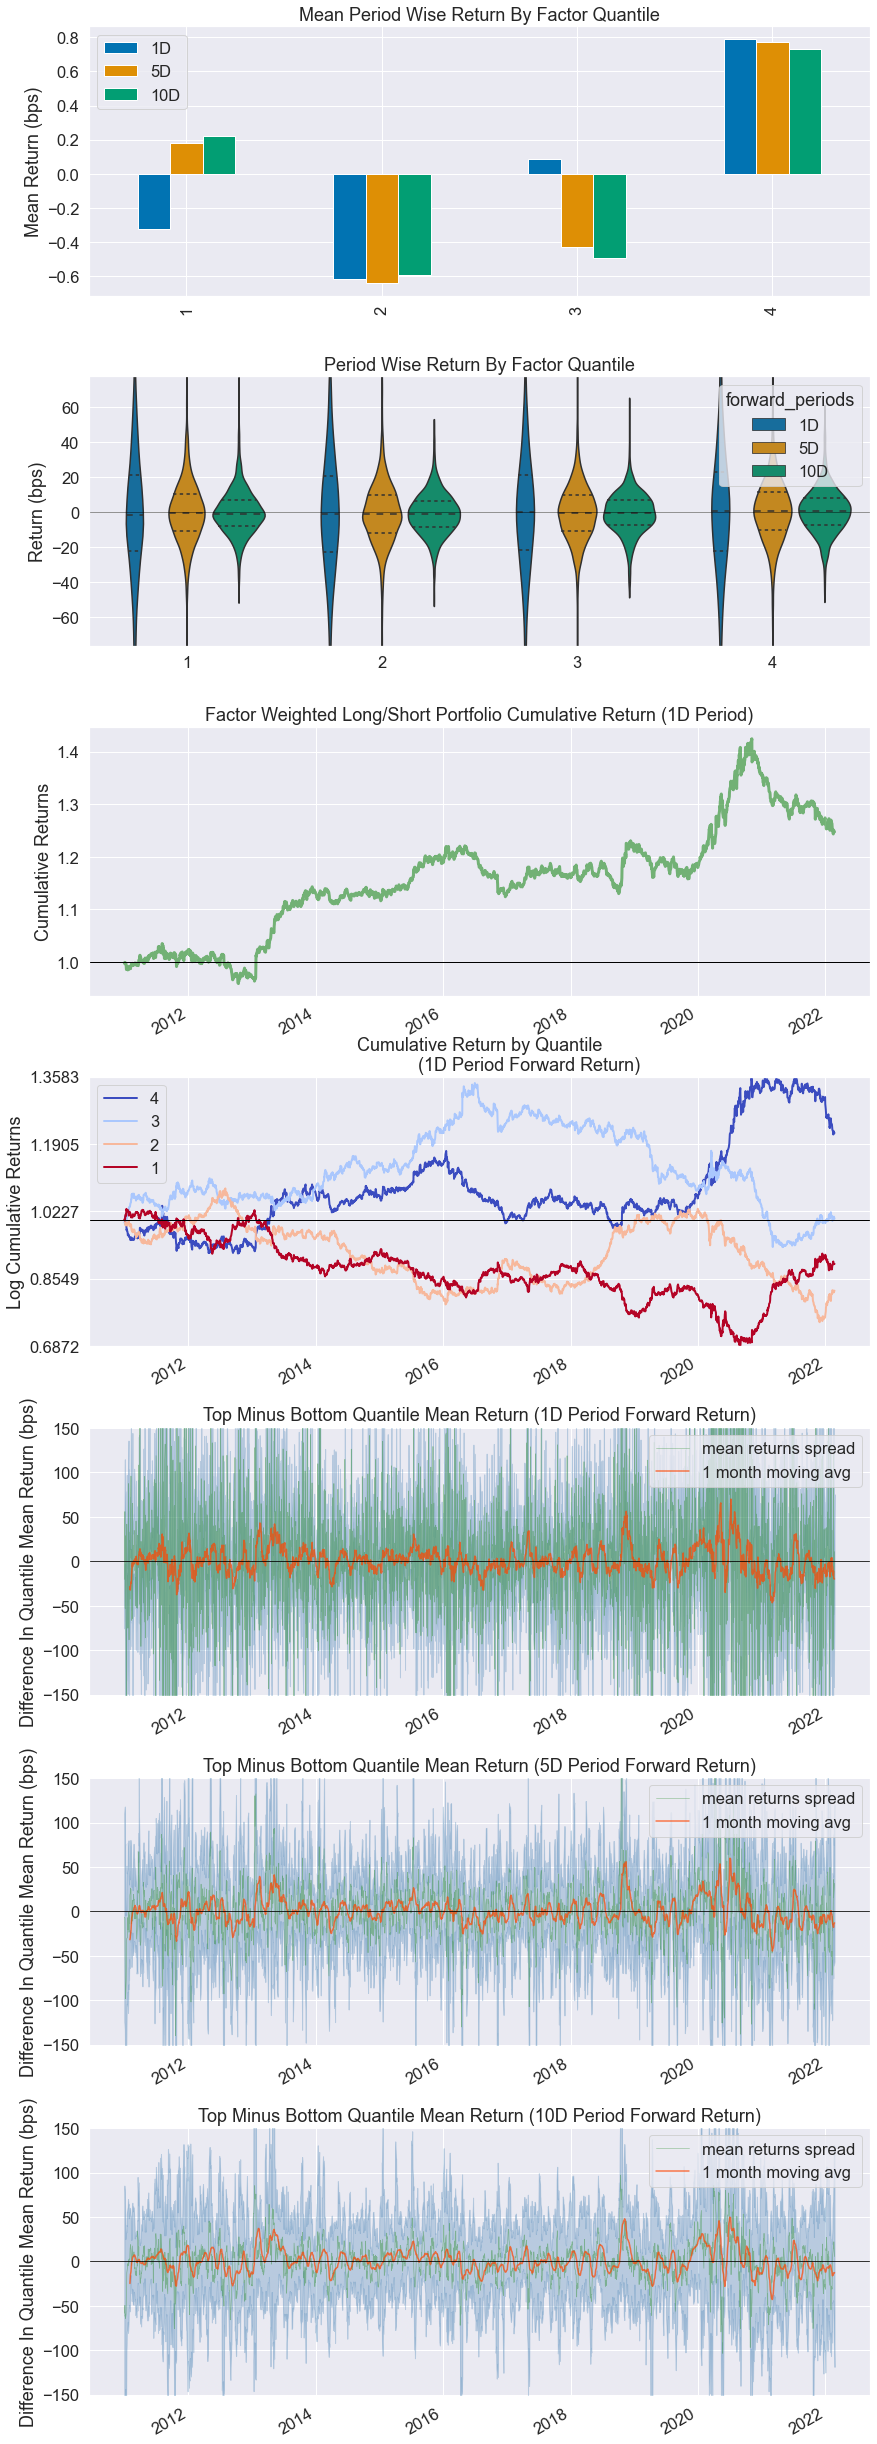

Information Analysis


,1D,5D,10D
IC Mean,0.007,0.008,0.007
IC Std.,0.172,0.168,0.166
Risk-Adjusted IC,0.039,0.045,0.042
t-stat(IC),2.063,2.397,2.206
p-value(IC),0.039,0.017,0.027
IC Skew,0.052,-0.025,-0.083
IC Kurtosis,-0.092,-0.117,-0.221


/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

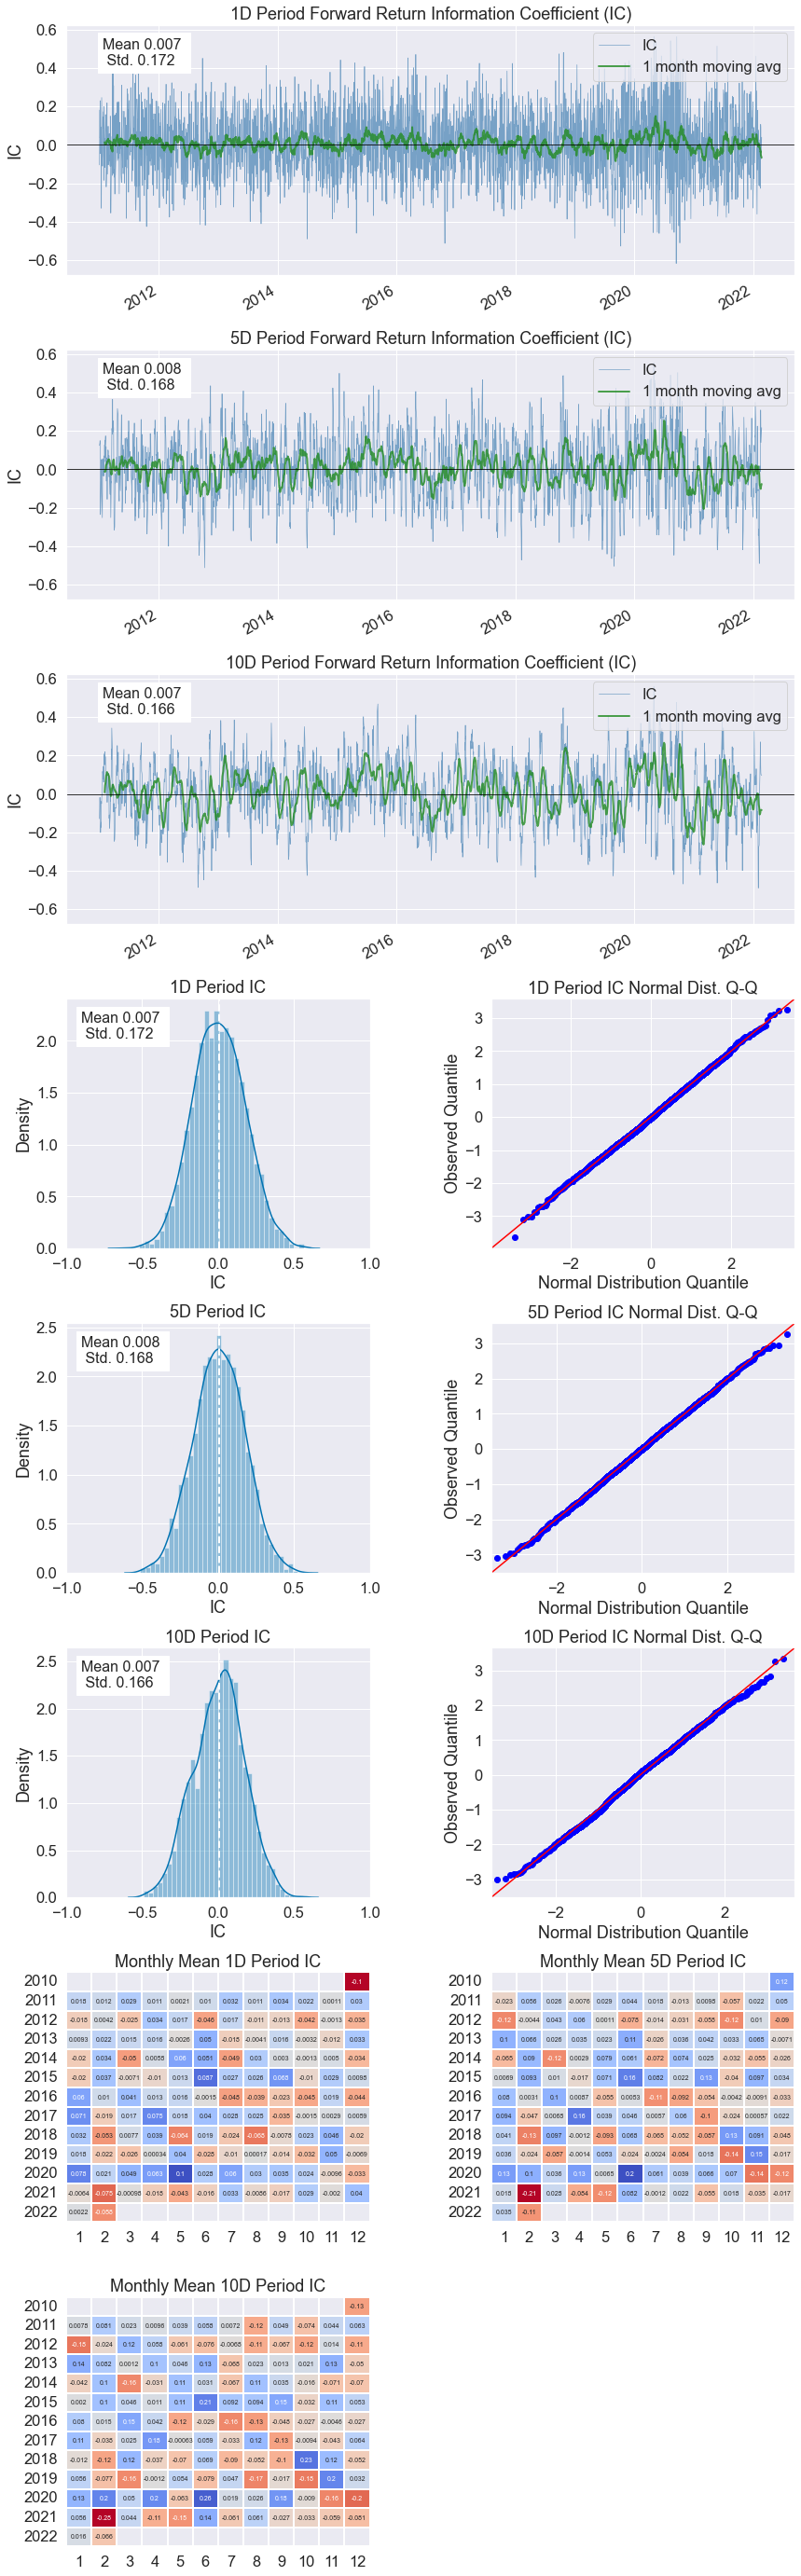

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.011,0.046,0.084
Quantile 2 Mean Turnover,0.021,0.088,0.154
Quantile 3 Mean Turnover,0.023,0.094,0.165
Quantile 4 Mean Turnover,0.012,0.050,0.092


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.994,0.971,0.943


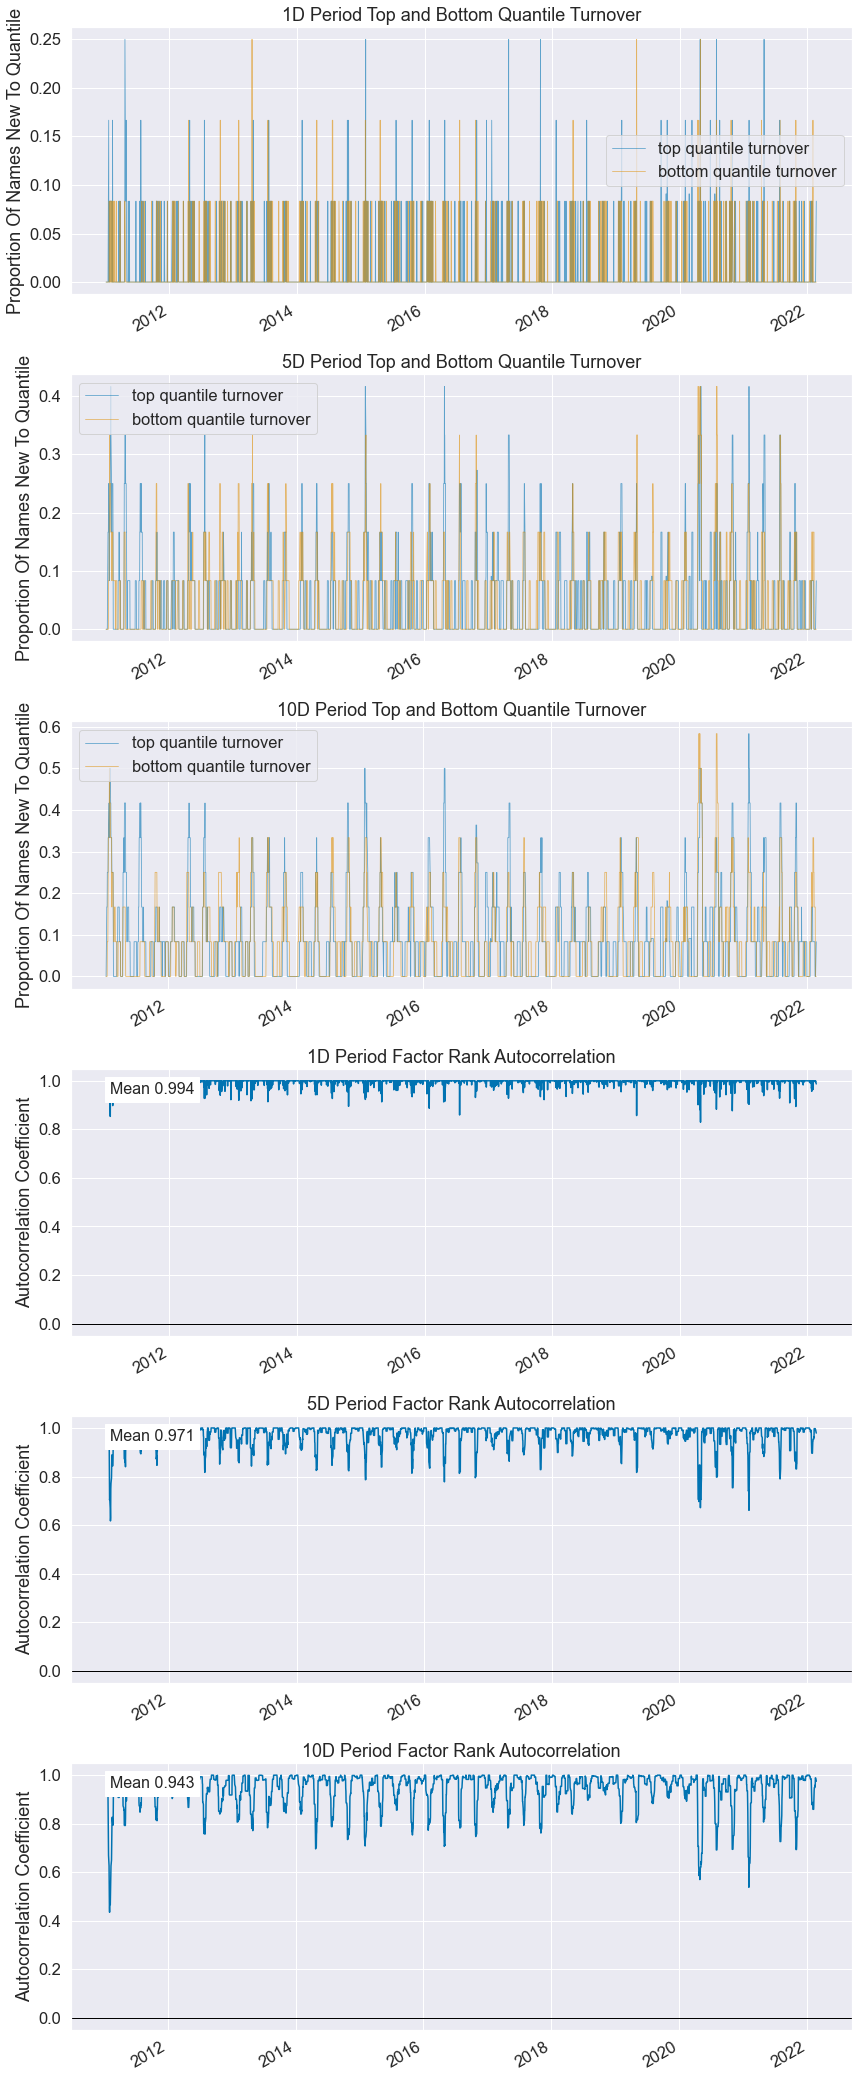

In [37]:
factor = 'Mean' 
factor_analysis(factor)

In [ ]:
# factor = 'Flesch score' 
# factor_analysis(factor)

In [ ]:
# factor = 'Polysyllable number per sentence' 
# factor_analysis(factor)